# Import Data

In [322]:
import numpy as np
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought/Data/"
file=directory+"Pressure/hgt.mon.mean.nc"
nc=Dataset(file,'r')
pressure=nc.variables["hgt"][0:815,7,0:48,48:112]
#file=directory+"Pressure/hgt.mon.mean.nc"
#nc=Dataset(file,'r')
#pressure=nc.variables["slp"][0:815,0:48,48:112]
#pressure=nc.variables["slp"][0:816,0:28,0:28]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=CAMonthTotal.reshape((816, 1))
ORMonthTotal=ORMonthTotal.reshape((816, 1))
WCMonthTotal=WCMonthTotal.reshape((816, 1))
CAMonthTotal=CAMonthTotal[1:816,:]
rlat=48
rlon=64
x_data=pressure.flatten()
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(815,rlat,rlon,1))
y_data=(CAMonthTotal-np.mean(CAMonthTotal))/np.std(CAMonthTotal)

In [323]:
cd '/Users/lambda/Documents/Code/Lib/TensorFlow'

/Users/lambda/Documents/Code/Lib/TensorFlow


# Set Computing Graph

### HyperParameters

In [324]:
ptraining=576
ctraining=[]
ctest=[]
#Convolution Layer Parameters
wc1=3
nc1=2
wc2=5
nc2=1
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
wfc=50
wfc2=10

### Graph

In [325]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,1])
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.001,name="W_conv1")),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.001)),
               'W_fc':tf.Variable(tf.random_normal([fl,wfc],stddev=0.001)),
               'W_fc2':tf.Variable(tf.random_normal([wfc,wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([wfc2, 1],stddev=0.001))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc':tf.Variable(tf.random_normal([wfc],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([1],stddev=0.001))}
    
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp1)

    fc = tf.reshape(pool2,[-1, fl])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc2 = tf.nn.relu(tf.matmul(fc, weights['W_fc2'])+biases['b_fc2'])
    output = tf.matmul(fc2, weights['out'])+biases['out'] 
    return output

In [326]:
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(prediction-y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
all_saver = tf.train.Saver()

# Train

In [327]:
def train_neural_network(x):
    batch=120
    epoches=200
    gtestcost=np.inf
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoches):
            for b in range(ptraining/batch):
                epoch_x=x_data[b*batch:(b+1)*batch,:,:,:]
                epoch_y=y_data[b*batch:(b+1)*batch,:]
                sess.run(optimizer, feed_dict={x: epoch_x, y: epoch_y})
                trainingcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y})
                ctraining.append(trainingcost)
            testcost=sess.run(cost, feed_dict={x: x_data[ptraining:,:,:,:], 
                                                   y: y_data[ptraining:,:]})
            print testcost
            if testcost < gtestcost:
                gtestcost=testcost
                all_saver.save(sess, 'CNN_Trained')
            ctest.append(testcost)
        result=sess.run(prediction,feed_dict={x: x_data})
        sess.close()
    return result 

In [328]:
prediction_batch=train_neural_network(x)

0.859349
0.859627
0.859917
0.860189
0.859996
0.856866
0.842934
0.810733
0.807508
0.770677
0.767025
0.765425
0.752606
0.739046
0.717484
0.689695
0.665638
0.652088
0.64329
0.626836
0.613743
0.601978
0.595365
0.598287
0.595596
0.589485
0.585294
0.580559
0.57777
0.571058
0.565545
0.563007
0.561772
0.560449
0.559482
0.560151
0.561153
0.561882
0.560457
0.563707
0.564148
0.563515
0.560989
0.559816
0.559469
0.558959
0.558241
0.557672
0.555043
0.554861
0.555457
0.554685
0.555491
0.553569
0.554482
0.553676
0.552526
0.552503
0.552763
0.551645
0.551851
0.551271
0.55087
0.550224
0.550183
0.549675
0.549423
0.548899
0.548352
0.54816
0.547657
0.547261
0.546742
0.546478
0.546249
0.5453
0.545084
0.544581
0.544369
0.543842
0.542778
0.542739
0.542573
0.541849
0.5417
0.540895
0.540259
0.540014
0.538714
0.538364
0.537669
0.537037
0.537237
0.536901
0.536367
0.534355
0.53294
0.532897
0.531889
0.530701
0.530131
0.530751
0.530513
0.530351
0.529585
0.531915
0.529613
0.528774
0.530778
0.529973
0.529233
0.529176
0

In [329]:
[np.min(ctest),np.min(ctraining)]

[0.50560278, 0.40655455]

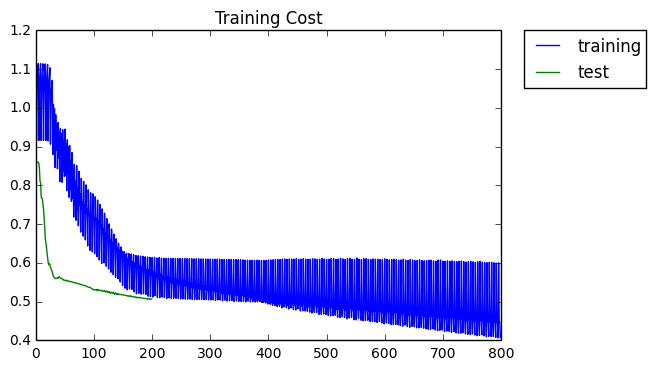

In [336]:
plt.plot(ctraining[0:800:4], label="training")
plt.plot(ctest,label="test")
plt.title("Training Cost")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Result

In [331]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/TensorFlow/CNN_Trained')
    trainingresult=sess.run(prediction,feed_dict={x:x_data[0:ptraining,:,:,:]})
    testresult=sess.run(prediction,feed_dict={x:x_data[ptraining:,:,:,:]})

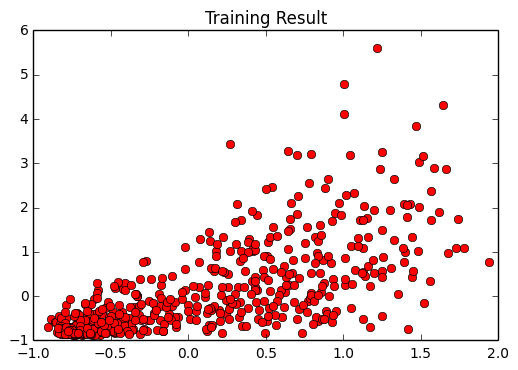

In [332]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[0:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

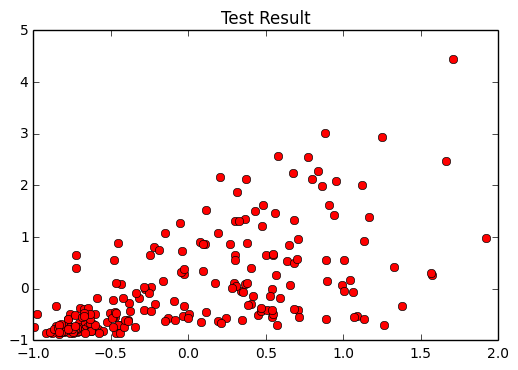

In [333]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining:,:],'ro')
plt.title("Test Result")
plt.show()

In [334]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.3748506813485642,
 0.34926209082558202,
 0.30653632305910328,
 0.18035061774423417,
 0.044700731849705258,
 -0.18778217541657874,
 -0.089950251255865379,
 0.0064251316244734059,
 0.35012240238441805,
 0.37190573485625622,
 0.22904773519245003,
 0.44735562998083128]

In [335]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    

[0.27817371719031025,
 0.12200503198549033,
 -0.11028305663859336,
 -0.24996687804220222,
 -0.090527170354401693,
 0.51918832061146858,
 0.17808899083637067,
 0.055643051004919543,
 -0.068028370826578075,
 -0.12924122435275506,
 -0.11735159985197358,
 0.083309313420535366]